In [1]:
import numpy as np
import cmath as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
import os
import seaborn as sns
from shared.figures import *
%matplotlib widget
mpl.rcParams.update({'font.size': 14})
plt.rcParams['axes.axisbelow'] = True
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["b", "r", "g", 'k','y' , 'm','tab:orange', 'tab:cyan', 'tab:brown', 'slategrey', 'deeppink' ]) 

# The pros and cons of using deep reinforcement learning or genetic algorithms to design control schemes for quantum state transfer on qubit chains

Authors: **Sofía Perón Santana**, Ariel Fiuri, Omar Osenda, Martín Domínguez.

--- 

This notebook collects the main figures presented in the work *The pros and cons of using deep reinforcement learning or genetic algorithms to design control schemes for quantum state transfer on qubit chains*. It compares different performance metrics for the two approaches and analyzes their respective strengths and limitations in the context of quantum state transfer.

### Genetic algorithm performance

We first access genetic algorithm results stored in ```genetic_algorithm/results/``` directory. If we list the contents of this directory we can access the different experiments:

In [2]:
print(sorted(os.listdir('genetic_algorithm/results')))

['loc_based_fitness_oaps_actions_95', 'loc_based_fitness_oaps_actions_99', 'loc_based_fitness_zhang_actions_95', 'loc_based_fitness_zhang_actions_99', 'reward_based_fitness_large_dims_oaps', 'reward_based_fitness_oaps_actions_95', 'reward_based_fitness_oaps_actions_99', 'reward_based_fitness_zhang_actions_95', 'reward_based_fitness_zhang_actions_99']


In particular, we will study the results obtained using "*reward based fitness*" which is derived from the DRL reward expression proposed in [1]. Also, we access the solutions where we required at least 99% fidelity for the iterations to stop (a max iteration condition is also applied in case the required fidelity is never reached.).

We will compare the results found using an action on each site (oaps) and the actions proposed in the original paper. The complete set of hyper-parameters and system parameters can be found in an .ini file inside each directory.


In [3]:
# accessing genetic algorithm results
path = 'genetic_algorithm/results/'

# action by site (oaps, one action per site)
ga_abs_directory = 'reward_based_fitness_oaps_actions_99/'
ga_abs_results = extract_ga_results(path + ga_abs_directory, print_params=True)
ga_abs_results['method'] = 'GA-ABS'

# zhang et al. actions
ga_zhang_directory = 'reward_based_fitness_zhang_actions_99/'
ga_zhang_results = extract_ga_results(path + ga_zhang_directory, print_params=True)
ga_zhang_results['method'] = 'GA-Zhang'


# ------------------------------------------------------------
Printing parameters from reward_based_fitness_oaps_actions_99 
Number of samples: 30
# ------------------------------------------------------------

[system_parameters]
initial_n = 8                 dt = 0.15                     action_set = oaps             
final_n = 64                  b = 100                       speed_fraction = 0            
n_step = 4                    coupling = 1.0                

[ga_initialization]
num_generations = 1000        fidelity_tolerance = 0.01     reward_decay = 0.95           
num_genes = 5*n               saturation = 30               
sol_per_pop = 4096            fitness_function = reward_based

[parent_selection]
num_parents_mating = 409      parent_selection_type = sss   keep_elitism = 409            

[crossover]
crossover_type = uniform      crossover_probability = 0.8   

[mutation]
mutation_probability = 0.99   mutation_num_genes = n        
# ------------------------------

#### Comparison of genetic algorithm performance for different action sets (Figure 4).

We ran 30 samples of the genetic algorithm for each case. In the following graph, we compare the mean and max transmission probability value obtained for each experiment (left) and we show an example of the time evolution of fidelity for a chain of 32 qubits (right).

To see other evolutions, just change the ```chain_length``` parameter.

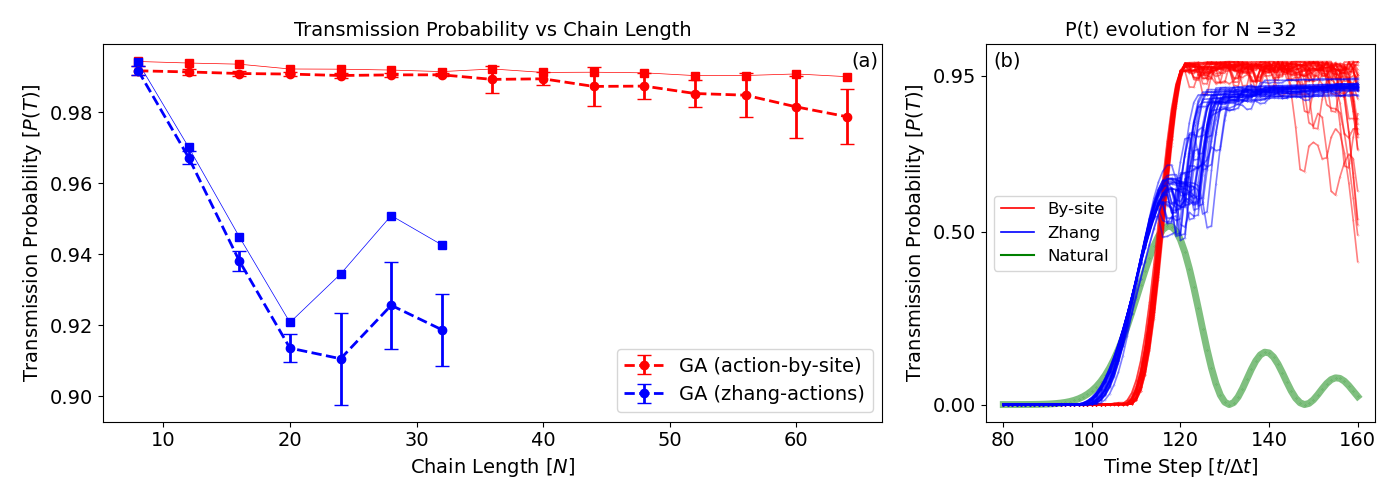

In [4]:
font_size = 14
chain_length = 32

# extract stats from both experiments
ga_oaps_stats = ga_abs_results.groupby('chain_length').agg({'max_fidelity': ['mean', 'std', 'max', 'min'], 'cpu_time': ['mean', 'std', 'max', 'min'] }).reset_index()
#ga_oaps_stats = ga_oaps_stats[ga_oaps_stats['chain_length'] <= 32]

ga_zhang_stats = ga_zhang_results.groupby('chain_length').agg({'max_fidelity': ['mean', 'std', 'max', 'min'], 'cpu_time': ['mean', 'std', 'max', 'min']}).reset_index()

# set side by side figure
fig = plt.figure(figsize=(14, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])  # 2/3 y 1/3
ax_main = fig.add_subplot(gs[0])
ax_side = fig.add_subplot(gs[1])

# main plot: mean max_fidelityelity vs chain length
ax = ax_main
ax.errorbar(ga_oaps_stats['chain_length'], ga_oaps_stats[('max_fidelity', 'mean')], yerr=ga_oaps_stats[('max_fidelity', 'std')], fmt='o--',
            label='GA (action-by-site)', color='red', capsize=5)
ax.plot(ga_oaps_stats['chain_length'], ga_oaps_stats[('max_fidelity', 'max')], 's-', color='red', linewidth=0.5)

ax.errorbar(ga_zhang_stats['chain_length'], ga_zhang_stats[('max_fidelity', 'mean')], yerr=ga_zhang_stats[('max_fidelity', 'std')], fmt='o--',
            label='GA (zhang-actions)', color='blue', capsize=5)
ax.plot(ga_zhang_stats['chain_length'], ga_zhang_stats[('max_fidelity', 'max')], 's-', color='blue', linewidth=0.5)

ax.set_xlabel('Chain Length $[N]$', fontsize=font_size)
ax.set_ylabel('Transmission Probability $[P(T)]$', fontsize=font_size)
ax.set_title('Transmission Probability vs Chain Length', fontsize=font_size)
ax.tick_params(axis='both', labelsize=font_size)
ax.legend(fontsize=font_size)

# side plot: max_fidelityelity evolution
ga_abs_max_fidelity_evolutions, natural_evolution = access_ga_evolutions(path + ga_abs_directory, chain_length, return_natural_evolution=True)
ga_zhang_max_fidelity_evolutions = access_ga_evolutions(path + ga_zhang_directory, chain_length, return_natural_evolution=False)

initial_plot_step = int(2.5*chain_length) # dont plot the initial steps (redundant)

for evolution in ga_abs_max_fidelity_evolutions:
    ax_side.plot(range(len(evolution))[initial_plot_step:],
             evolution[initial_plot_step:], '-o', color='red',
             alpha=0.5, linewidth=1.2, markersize=0.2)

for evolution in ga_zhang_max_fidelity_evolutions:
    ax_side.plot(range(len(evolution))[initial_plot_step:],
             evolution[initial_plot_step:], '-o', color='blue',
             alpha=0.5, linewidth=1.2, markersize=0.2)

# Curva Natural
ax_side.plot(range(len(evolution))[initial_plot_step:],
         natural_evolution[initial_plot_step:], '-o', label='Natural',
         color='green', alpha=0.5, linewidth=5, markersize=0.2, zorder=-2)
ax_side.set_ylabel('Transmission Probability $[P(T)]$', fontsize=font_size)
ax_side.set_xlabel('Time Step $[ t/\Delta t]$', fontsize=font_size)
ax_side.set_yticks([0., 0.5, 0.95])
ax_side.tick_params(axis='both', labelsize=font_size)
ax_side.set_title(f"P(t) evolution for N ={chain_length}", fontsize=font_size)

# Add subplot labels
ax.text(0.96, 0.98, '(a)', transform=ax.transAxes,
    fontsize=font_size, verticalalignment='top', horizontalalignment='left',
    bbox=dict(facecolor='white', alpha=0, edgecolor='none'))

ax_side.text(0.02, 0.98, '(b)', transform=ax_side.transAxes,
     fontsize=font_size, verticalalignment='top', horizontalalignment='left',
     bbox=dict(facecolor='none', alpha=0, edgecolor='none'))

legend_elements = [
    Line2D([0], [0], color='red', lw=1.2, label='By-site'),
    Line2D([0], [0], color='blue', lw=1.2, label='Zhang'),
    Line2D([0], [0], color='green', lw=1.5, label='Natural')
]
ax_side.legend(handles=legend_elements, fontsize=font_size-2, loc='center left')
############################################

plt.tight_layout()
plt.savefig(f'figures/genetic_action_comparison_n{chain_length}.png', dpi=1024, bbox_inches='tight')
plt.show()



### Transmission probability obtained using the original DRL model

We ran the original DRL implementation. Since the original source code reports on max fidelities obtained during training (not validation), we study the sequences that provided the 10 best transmission probability values during model training. We compar

In [5]:
# Extracting DRL original implementation results
drl_path = 'adapted_zhang_implementation/original_drl_results/'

chain_lengths = [8,12,16,20,24,32]
fidelities = pd.DataFrame()

fidelities = pd.DataFrame(columns=['chain_length', 'method', 'max_fidelity'])

for chain_length in chain_lengths:
    directory = drl_path + f'n{chain_length}_original_parameters'
    best_fids = np.loadtxt(directory + '/best_fidelities.txt', dtype=np.float32)
    for fid in best_fids:
        fidelities = pd.concat([fidelities, pd.DataFrame({'chain_length': [chain_length], 'method': ['zhang'], 'max_fidelity': [fid]})], ignore_index=True)

# Stats extraction for DRL
drl_original_stats = fidelities.groupby('chain_length').agg({'max_fidelity': ['mean', 'std', 'max', 'min']}).reset_index()

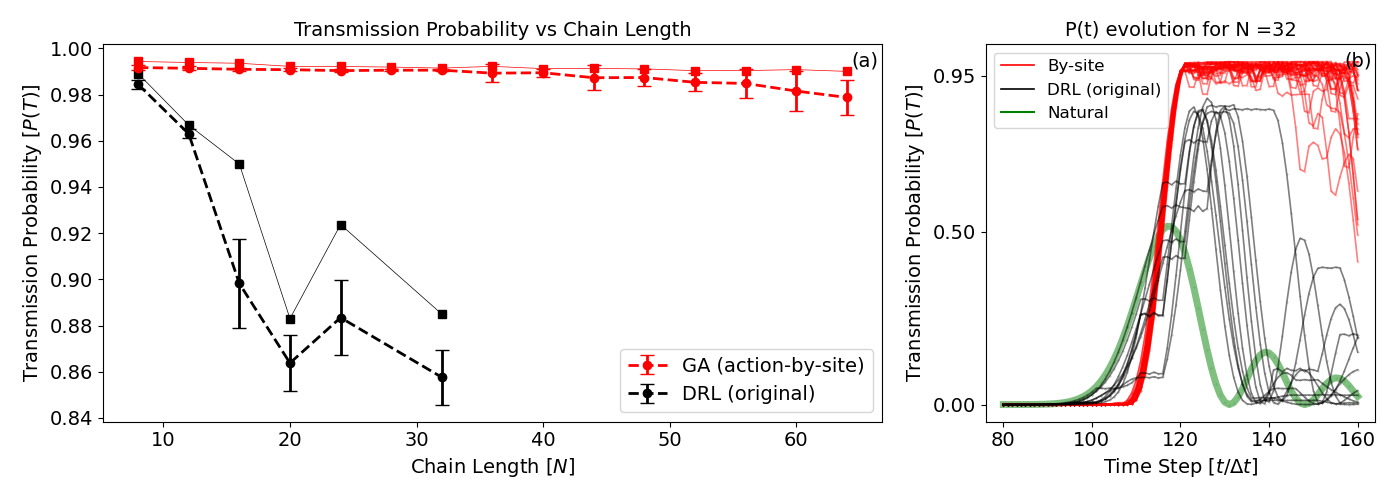

In [6]:
font_size = 14
chain_length = 32


# set side by side figure
fig = plt.figure(figsize=(14, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])  # 2/3 y 1/3
ax_main = fig.add_subplot(gs[0])
ax_side = fig.add_subplot(gs[1])

# main plot: mean fidelity vs chain length
ax = ax_main
ax.errorbar(ga_oaps_stats['chain_length'], ga_oaps_stats[('max_fidelity', 'mean')], yerr=ga_oaps_stats[('max_fidelity', 'std')], fmt='o--',
            label='GA (action-by-site)', color='red', capsize=5)
ax.plot(ga_oaps_stats['chain_length'], ga_oaps_stats[('max_fidelity', 'max')], 's-', color='red', linewidth=0.5)

ax.errorbar(drl_original_stats['chain_length'], drl_original_stats[('max_fidelity', 'mean')], yerr=drl_original_stats[('max_fidelity', 'std')], fmt='o--',
            label='DRL (original)', color='black', capsize=5)
ax.plot(drl_original_stats['chain_length'], drl_original_stats[('max_fidelity', 'max')], 's-', color='black', linewidth=0.5)

ax.set_xlabel('Chain Length $[N]$', fontsize=font_size)
ax.set_ylabel('Transmission Probability $[P(T)]$', fontsize=font_size)
ax.set_title('Transmission Probability vs Chain Length', fontsize=font_size)
ax.tick_params(axis='both', labelsize=font_size)
ax.legend(fontsize=font_size)

# side plot: fidelity evolution
ga_abs_fid_evolutions, natural_evolution = access_ga_evolutions(path + ga_abs_directory, chain_length, return_natural_evolution=True)
original_zhang_fid_evolutions = access_drl_evolutions(drl_path, chain_length, return_natural_evolution=False)
initial_plot_step = int(2.5*chain_length) # dont plot the initial steps (redundant)

for evolution in ga_abs_fid_evolutions:
    ax_side.plot(range(len(evolution))[initial_plot_step:],
             evolution[initial_plot_step:], '-o', color='red',
             alpha=0.5, linewidth=1.2, markersize=0.2)

for evolution in original_zhang_fid_evolutions:
    ax_side.plot(range(len(evolution))[initial_plot_step:],
             evolution[initial_plot_step:], '-o', color='black',
             alpha=0.5, linewidth=1.2, markersize=0.2)

# Natural evolution
ax_side.plot(range(len(evolution))[initial_plot_step:],
         natural_evolution[initial_plot_step:], '-o', label='Natural',
         color='green', alpha=0.5, linewidth=5, markersize=0.2, zorder=-2)
ax_side.set_ylabel('Transmission Probability $[P(T)]$', fontsize=font_size)
ax_side.set_xlabel('Time Step $[ t/\Delta t]$', fontsize=font_size)
ax_side.set_yticks([0., 0.5, 0.95])
ax_side.tick_params(axis='both', labelsize=font_size)
ax_side.set_title(f"P(t) evolution for N ={chain_length}", fontsize=font_size)

# Add subplot labels
ax.text(0.96, 0.98, '(a)', transform=ax.transAxes,
    fontsize=font_size, verticalalignment='top', horizontalalignment='left',
    bbox=dict(facecolor='white', alpha=0., edgecolor='none'))

ax_side.text(0.92, 0.98, '(b)', transform=ax_side.transAxes,
     fontsize=font_size, verticalalignment='top', horizontalalignment='left',
     bbox=dict(facecolor='none', alpha=0., edgecolor='none'))

legend_elements = [
    Line2D([0], [0], color='red', lw=1.2, label='By-site'),
    Line2D([0], [0], color='black', lw=1.2, label='DRL (original)'),
    Line2D([0], [0], color='green', lw=1.5, label='Natural')
]
ax_side.legend(handles=legend_elements, fontsize=font_size-2, loc='upper left')
############################################

plt.tight_layout()
plt.savefig(f'figures/genetic_vs_drl_n{chain_length}.png', dpi=1024, bbox_inches='tight')
plt.show()



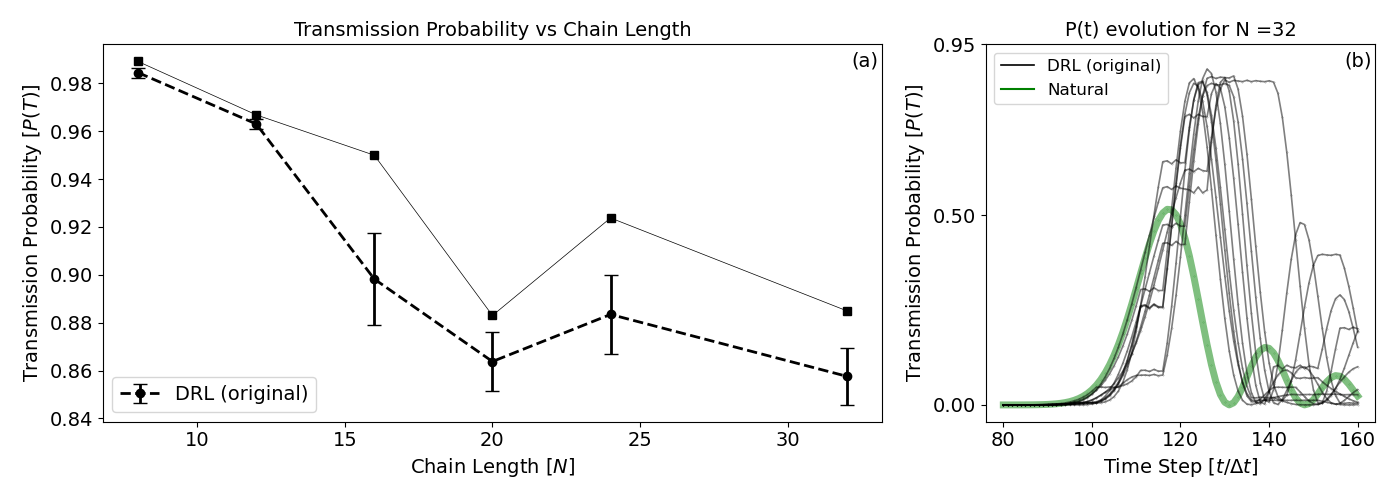

In [7]:
font_size = 14
chain_length = 32


# set side by side figure
fig = plt.figure(figsize=(14, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])  # 2/3 y 1/3
ax_main = fig.add_subplot(gs[0])
ax_side = fig.add_subplot(gs[1])

# main plot: mean fidelity vs chain length
ax = ax_main
ax.errorbar(drl_original_stats['chain_length'], drl_original_stats[('max_fidelity', 'mean')], yerr=drl_original_stats[('max_fidelity', 'std')], fmt='o--',
            label='DRL (original)', color='black', capsize=5)
ax.plot(drl_original_stats['chain_length'], drl_original_stats[('max_fidelity', 'max')], 's-', color='black', linewidth=0.5)

ax.set_xlabel('Chain Length $[N]$', fontsize=font_size)
ax.set_ylabel('Transmission Probability $[P(T)]$', fontsize=font_size)
ax.set_title('Transmission Probability vs Chain Length', fontsize=font_size)
ax.tick_params(axis='both', labelsize=font_size)
ax.legend(fontsize=font_size, loc = 'lower left')

# side plot: fidelity evolution
original_zhang_fid_evolutions = access_drl_evolutions(drl_path, chain_length, return_natural_evolution=False)
initial_plot_step = int(2.5*chain_length) # dont plot the initial steps (redundant)

for evolution in original_zhang_fid_evolutions:
    ax_side.plot(range(len(evolution))[initial_plot_step:],
             evolution[initial_plot_step:], '-o', color='black',
             alpha=0.5, linewidth=1.2, markersize=0.2)

# Natural evolution
ax_side.plot(range(len(evolution))[initial_plot_step:],
         natural_evolution[initial_plot_step:], '-o', label='Natural',
         color='green', alpha=0.5, linewidth=5, markersize=0.2, zorder=-2)
ax_side.set_ylabel('Transmission Probability $[P(T)]$', fontsize=font_size)
ax_side.set_xlabel('Time Step $[ t/\Delta t]$', fontsize=font_size)
ax_side.set_yticks([0., 0.5, 0.95])
ax_side.tick_params(axis='both', labelsize=font_size)
ax_side.set_title(f"P(t) evolution for N ={chain_length}", fontsize=font_size)

# Add subplot labels
ax.text(0.96, 0.98, '(a)', transform=ax.transAxes,
    fontsize=font_size, verticalalignment='top', horizontalalignment='left',
    bbox=dict(facecolor='white', alpha=0., edgecolor='none'))

ax_side.text(0.92, 0.98, '(b)', transform=ax_side.transAxes,
     fontsize=font_size, verticalalignment='top', horizontalalignment='left',
     bbox=dict(facecolor='none', alpha=0., edgecolor='none'))

legend_elements = [
    Line2D([0], [0], color='black', lw=1.2, label='DRL (original)'),
    Line2D([0], [0], color='green', lw=1.5, label='Natural')
]
ax_side.legend(handles=legend_elements, fontsize=font_size-2, loc='upper left')
############################################

plt.tight_layout()
plt.savefig(f'figures/drl_fidelity_n{chain_length}.png', dpi=1024, bbox_inches='tight')
plt.show()



## CPU times
It is also interesting to highlight that the genetic algorithm exhibits a significant advantage in terms of computational efficiency. The following figure shows the time required to train a DRL model and the time required to perform a single run of the genetic algorithm. Since, in the case of reinforcement learning, it was not possible to perform statistical analysis of the training times (because this would require multiple training runs with prohibitively long durations) we compare against the maximum search time observed for the genetic algorithm.

Execution times in DRL could potentially be reduced through further optimizations. However, due to the implementation nature of the genetic algorithm, it is easily parallelizable on GPUs, which allows for a substantial reduction in computation time.

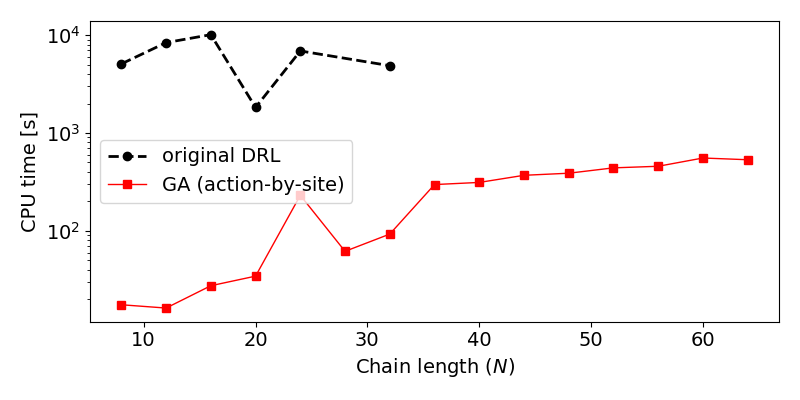

In [8]:
drl_times = pd.read_csv('adapted_zhang_implementation/original_drl_results/cpu_times.csv')

plt.figure(figsize=(8, 4))
plt.plot(chain_lengths, drl_times['cpu_time'], 'o--', label='original DRL', color='black')
plt.plot(ga_oaps_stats['chain_length'], ga_oaps_stats[('cpu_time', 'max')], 's-', label='GA (action-by-site)', color='red', linewidth=1)
plt.xlabel('Chain length ($N$)', fontsize=font_size)
plt.ylabel('CPU time [s]', fontsize=font_size)
plt.legend(fontsize=font_size, loc='center left')
plt.yscale('log')

plt.tight_layout()
plt.savefig('figures/zhang_drl_ga_cpu_times_ls.png', dpi=1024, bbox_inches='tight')



## Stats on Genetic Algorithm actions 

Given the low computation times of GA, we recovered 1000 samples for chains of 16 and 32 qubits to study action distributions in action-by-site.
We notice there are more actions done on the last two sites.


[ 7. 13. 27. ... 25. 32. 16.]
Number of times action 32 appears: 19356


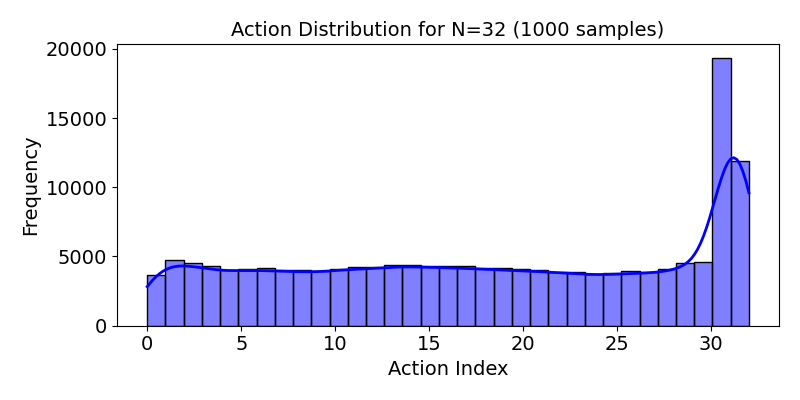

In [9]:
path = 'genetic_algorithm/action_stats/reward_based_fitness_oaps_stats_for_n32/'
ga_stats_actions = np.genfromtxt(path + 'n32.txt')
print(ga_stats_actions.flatten())
count_32 = np.sum(ga_stats_actions.flatten() == 31)
print(f"Number of times action 32 appears: {count_32}")
plt.figure(figsize=(8, 4))
sns.histplot(ga_stats_actions.flatten(), bins=33, kde=True)

plt.xlabel('Action Index', fontsize=font_size)
plt.ylabel('Frequency', fontsize=font_size)
plt.title('Action Distribution for N=32 (1000 samples)', fontsize=font_size)
plt.tight_layout()
plt.savefig('figures/action_distribution_n32.png', dpi=1024, bbox_inches='tight')
plt.show()

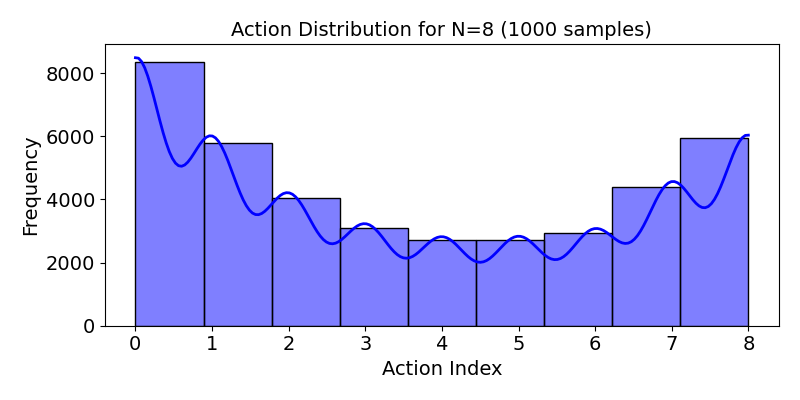

In [13]:
path = 'genetic_algorithm/action_stats/reward_based_fitness_oaps_stats_for_n8/'
ga_stats_actions = np.genfromtxt(path + 'n8.txt')

plt.figure(figsize=(8, 4))
sns.histplot(ga_stats_actions.flatten(), bins=9, kde=True)

plt.xlabel('Action Index', fontsize=font_size)
plt.ylabel('Frequency', fontsize=font_size)
plt.title('Action Distribution for N=8 (1000 samples)', fontsize=font_size)
plt.tight_layout()
plt.savefig('figures/action_distribution_n8.png', dpi=1024, bbox_inches='tight')
plt.show()

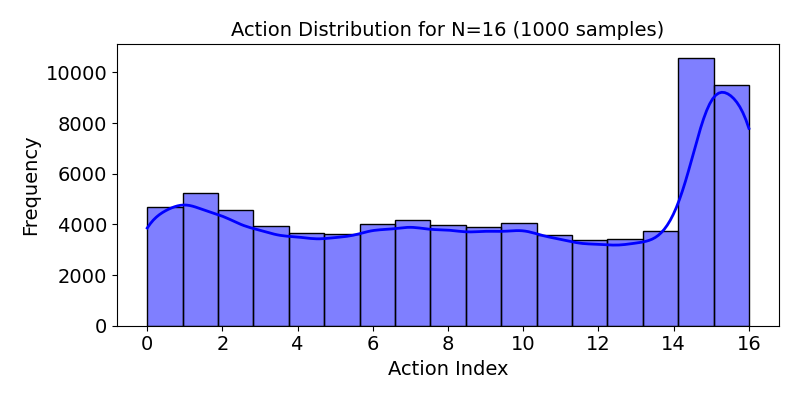

In [10]:
path = 'genetic_algorithm/action_stats/reward_based_fitness_oaps_stats_for_n16/'
ga_stats_actions = np.genfromtxt(path + 'n16.txt').flatten()
path2 = 'genetic_algorithm/action_stats/reward_based_fitness_oaps_stats_for_n16_2/'
ga_stats_actions2 = np.genfromtxt(path2 + 'n16.txt').flatten()
ga_stats_actions = np.concatenate((ga_stats_actions, ga_stats_actions2), axis=0)


plt.figure(figsize=(8, 4))
sns.histplot(ga_stats_actions.flatten(), bins=17, kde=True)

plt.xlabel('Action Index', fontsize=font_size)
plt.ylabel('Frequency', fontsize=font_size)
plt.title('Action Distribution for N=16 (1000 samples)', fontsize=font_size)
plt.tight_layout()
plt.savefig('figures/action_distribution_n16.png', dpi=1024, bbox_inches='tight')
plt.show()

### Results for large dimensions

We tested the limits of the algorithm by trying to find an optimal action sequence for larger chains. 

In [21]:
# accessing genetic algorithm results
path = 'genetic_algorithm/results/'

# action by site large dims  (oaps, one action per site)
ga_abs_directory_large = 'reward_based_fitness_large_dims_oaps/'
ga_abs_results_large = extract_ga_results(path + ga_abs_directory_large, print_params=False)
ga_abs_results_large['method'] = 'GA-ABS'

ga_abs_results_complete = pd.concat([ga_abs_results, ga_abs_results_large], ignore_index=True)



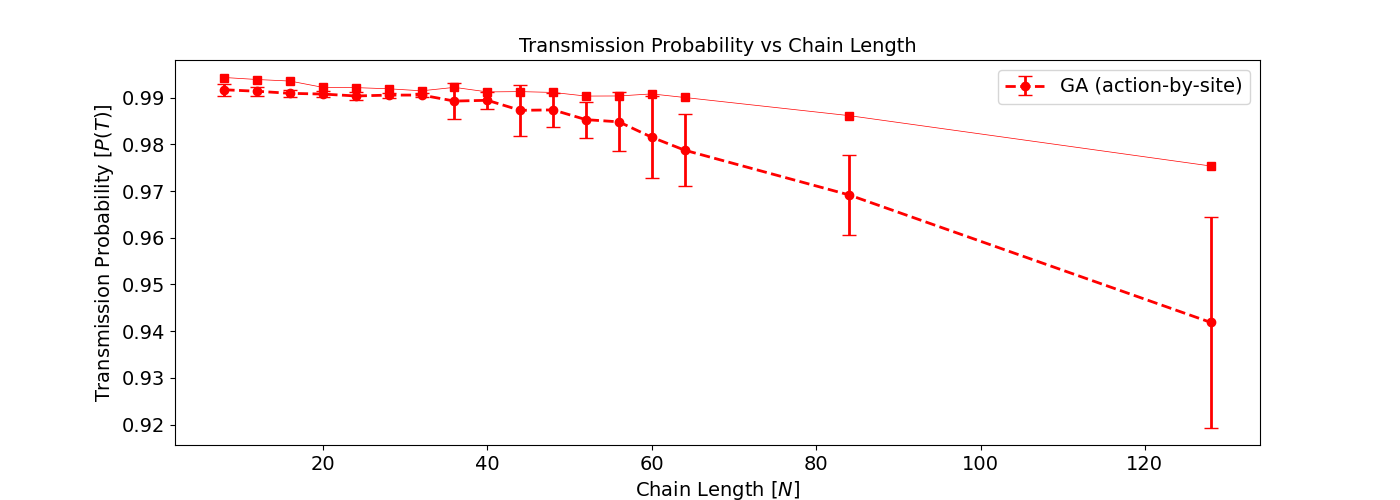

In [19]:
ga_oaps_stats_complete = ga_abs_results_complete.groupby('chain_length').agg({'max_fidelity': ['mean', 'std', 'max', 'min'], 'cpu_time': ['mean', 'std', 'max', 'min'] }).reset_index()

# set side by side figure
fig = plt.figure(figsize=(14, 5))

plt.errorbar(ga_oaps_stats_complete['chain_length'], ga_oaps_stats_complete[('max_fidelity', 'mean')], yerr=ga_oaps_stats_complete[('max_fidelity', 'std')], fmt='o--',
            label='GA (action-by-site)', color='red', capsize=5)
plt.plot(ga_oaps_stats_complete['chain_length'], ga_oaps_stats_complete[('max_fidelity', 'max')], 's-', color='red', linewidth=0.5)

plt.xlabel('Chain Length $[N]$', fontsize=font_size)
plt.ylabel('Transmission Probability $[P(T)]$', fontsize=font_size)
plt.title('Transmission Probability vs Chain Length', fontsize=font_size)
plt.tick_params(axis='both', labelsize=font_size)
plt.legend(fontsize=font_size)
plt.savefig(f'figures/genetic_for_large_dims.png', dpi=1024, bbox_inches='tight')